Chargement de notre dataset




In [ ]:
from google.colab import files

uploaded = files.upload()  # ouvre un bouton pour choisir ton fichier




Saving dataset 1.csv to dataset 1 (1).csv


PARTIE 1 : DATA ENGINEERING

 → préparation des données, encodage des labels, tokenisation, formatage pour PyTorch.

In [ ]:
# =============================
# 1️⃣ Installer les librairies
# =============================
!pip install -q transformers datasets

# =============================
# 2️⃣ Importer les modules
# =============================
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline, TextClassificationPipeline

# =============================
# 3️⃣ Charger et préparer le dataset
# =============================
dataset = load_dataset("csv", data_files="/content/dataset 1 (1).csv")

# Convertir labels en 0 = non-toxic, 1 = toxic
def encode_label(example):
    example['label'] = 1 if example['label'].lower() == 'toxic' else 0
    return example

dataset = dataset.map(encode_label)

# =============================
# 4️⃣ Tokenisation
# =============================
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)

dataset = dataset.map(tokenize, batched=True)
dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

PARTIE 2 : ML TRAINING & INFERENCE

In [ ]:
# =============================
# 5️⃣ Créer le modèle pour 2 labels
# =============================
model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# =============================
# 6️⃣ Configurer le Trainer
# =============================
training_args = TrainingArguments(
    output_dir="./toxic-finetuned",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"  # Désactive W&B
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['train']
)

# =============================
# 7️⃣ Entraîner le modèle
# =============================
trainer.train()

# =============================
# 8️⃣ Sauvegarder le modèle fine-tuné et le tokenizer
# =============================
trainer.save_model("./toxic-finetuned")
tokenizer.save_pretrained("./toxic-finetuned")

# =============================
# 9️⃣ Récupérer le modèle fine-tuné pour l'inférence
# =============================
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline

fine_tuned_model = AutoModelForSequenceClassification.from_pretrained("./toxic-finetuned")
fine_tuned_tokenizer = AutoTokenizer.from_pretrained("./toxic-finetuned")

toxicity_model = TextClassificationPipeline(
    model=fine_tuned_model,
    tokenizer=fine_tuned_tokenizer,
    return_all_scores=True
)

# Pipeline supplémentaire pour la toxicité (modèle pré-entraîné)
toxicity_models = [
    toxicity_model,
    pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-offensive", return_all_scores=True)
]

# Pipeline émotion
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=True
)

# =============================
# 10️⃣ Fonction d'analyse d'un texte
# =============================
def analyser_texte(texte, seuil=0.6, consensus=2):
    """
    seuil : score minimum pour considérer un texte comme toxique/offensive
    consensus : nombre de modèles qui doivent être d'accord pour bloquer
    """
    # Emotion
    resultat_emotion = emotion_classifier(texte)[0]
    emotion_dominante = max(resultat_emotion, key=lambda x: x['score'])

    # Toxicité
    blocage = False
    details_hate = []
    scores_block = 0

    for model in toxicity_models:
        resultat = model(texte)[0]
        # Corriger LABEL_0/LABEL_1 pour le modèle fine-tuné
        for r in resultat:
            if r['label'] == 'LABEL_0':
                r['label'] = 'non-toxic'
            elif r['label'] == 'LABEL_1':
                r['label'] = 'toxic'
        top_label = max(resultat, key=lambda x: x['score'])
        details_hate.append((top_label['label'], top_label['score']))
        if top_label['score'] > seuil and top_label['label'].lower() not in ['non-toxic', 'non-offensive', 'none']:
            scores_block += 1

    # Blocage seulement si consensus atteint
    blocage = scores_block >= consensus

    # Affichage
    print("Write your comment :", texte)
    print("Émotion dominante :", emotion_dominante['label'], "avec un score de", round(emotion_dominante['score'], 3))
    for label, score in details_hate:
        print("Modèle détecte :", label, "avec un score de", round(score, 3))
    print("Comment to block ?", "Yes" if blocage else "No")
    print("------")

# =============================
# 11️⃣ Tester un texte en boucle
# =============================
while True:
    texte_utilisateur = input("Entrez un texte (ou 'exit' pour quitter) : ")
    if texte_utilisateur.lower() == "exit":
        break
    analyser_texte(texte_utilisateur)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,0.651300
20,0.547300
30,0.276200
40,0.110600
50,0.041000
60,0.019900
70,0.012000
80,0.009200
90,0.007400
100,0.006000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


Entrez un texte (ou 'exit' pour quitter) : EXIT


PARTIE 3 : EVALUATION, VALIDATION AND FINAL CODE

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

{'train': Dataset({
    features: ['text', 'label'],
    num_rows: 350
}), 'validation': Dataset({
    features: ['text', 'label'],
    num_rows: 75
}), 'test': Dataset({
    features: ['text', 'label'],
    num_rows: 75
})}


Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2303757658.py:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.156500,0.059522,1.000000,1.000000,1.000000,1.000000
2,0.016800,0.010199,1.000000,1.000000,1.000000,1.000000
3,0.009600,0.007720,1.000000,1.000000,1.000000,1.000000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


📊 Résultats sur le set de validation :


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.05952214449644089, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 1.97, 'eval_samples_per_second': 38.071, 'eval_steps_per_second': 5.076, 'epoch': 3.0}

📊 Résultats sur le set de test :


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.060782190412282944, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 2.878, 'eval_samples_per_second': 26.059, 'eval_steps_per_second': 3.475, 'epoch': 3.0}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📑 Rapport détaillé par classe :
              precision    recall  f1-score   support

   non-toxic       1.00      1.00      1.00        38
       toxic       1.00      1.00      1.00        37

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



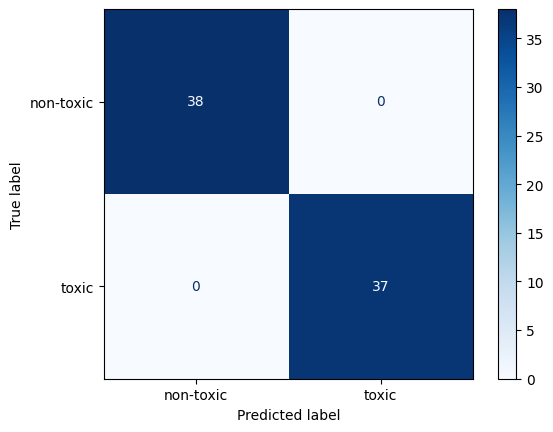

Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Device set to use cpu
Device set to use cpu


In [ ]:
# =============================
# 1️⃣ Installer les librairies
# =============================
!pip install -q transformers datasets scikit-learn

# =============================
# 2️⃣ Importer les modules
# =============================
from datasets import load_dataset, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline, TextClassificationPipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# =============================
# 3️⃣ Charger et préparer le dataset
# =============================
dataset = load_dataset("csv", data_files="/content/dataset 1 (1).csv")

# Convertir labels en 0 = non-toxic, 1 = toxic
def encode_label(example):
    example['label'] = 1 if example['label'].lower() == 'toxic' else 0
    return example

dataset = dataset.map(encode_label)

# Définir les labels
features = dataset['train'].features
features['label'] = ClassLabel(num_classes=2, names=['non-toxic', 'toxic'])
dataset = dataset.cast(features)

# Split 70% train / 15% val / 15% test
train_test = dataset['train'].train_test_split(test_size=0.3, stratify_by_column="label")
test_valid = train_test['test'].train_test_split(test_size=0.5, stratify_by_column="label")

dataset = {
    "train": train_test['train'],
    "validation": test_valid['train'],
    "test": test_valid['test']
}

print(dataset)

# =============================
# 4️⃣ Tokenisation
# =============================
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)

for split in dataset:
    dataset[split] = dataset[split].map(tokenize, batched=True)
    dataset[split].set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# =============================
# 5️⃣ Créer le modèle pour 2 labels
# =============================
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# =============================
# 6️⃣ Configurer Trainer + métriques
# =============================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="./toxic-finetuned",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=3,
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# =============================
# 7️⃣ Entraîner le modèle
# =============================
trainer.train()

# =============================
# 8️⃣ Résultats sur validation et test
# =============================
print("📊 Résultats sur le set de validation :")
val_results = trainer.evaluate(eval_dataset=dataset["validation"])
print(val_results)

print("\n📊 Résultats sur le set de test :")
test_results = trainer.evaluate(eval_dataset=dataset["test"])
print(test_results)

# Rapport détaillé + Matrice de confusion
predictions = trainer.predict(dataset["test"])
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

print("\n📑 Rapport détaillé par classe :")
print(classification_report(y_true, y_pred, target_names=["non-toxic", "toxic"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-toxic", "toxic"])
disp.plot(cmap="Blues")
plt.show()

# =============================
# 9️⃣ Pipelines (émotion + toxicité)
# =============================
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=True
)

toxicity_model = TextClassificationPipeline(
    model=trainer.model,
    tokenizer=tokenizer,
    return_all_scores=True
)

toxicity_models = [
    toxicity_model,
    pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-offensive", return_all_scores=True)
]

# =============================
# 🔟 Fonction d'analyse d'un texte
# =============================
def analyser_texte(texte, seuil=0.6, consensus=2):
    resultat_emotion = emotion_classifier(texte)[0]
    emotion_dominante = max(resultat_emotion, key=lambda x: x['score'])

    blocage = False
    details_hate = []
    scores_block = 0

    for model in toxicity_models:
        resultat = model(texte)[0]
        for r in resultat:
            if r['label'] == 'LABEL_0':
                r['label'] = 'non-toxic'
            elif r['label'] == 'LABEL_1':
                r['label'] = 'toxic'
        top_label = max(resultat, key=lambda x: x['score'])
        details_hate.append((top_label['label'], top_label['score']))
        if top_label['score'] > seuil and top_label['label'].lower() not in ['non-toxic', 'non-offensive', 'none']:
            scores_block += 1

    blocage = scores_block >= consensus

    print("Write your comment :", texte)
    print("Émotion dominante :", emotion_dominante['label'], "avec un score de", round(emotion_dominante['score'], 3))
    for label, score in details_hate:
        print("Modèle détecte :", label, "avec un score de", round(score, 3))
    print("Comment to block ?", "Yes" if blocage else "No")
    print("------")